### Clear GPU usage -- notebook loads and model and trains, does not clear cached memory

In [1]:
# Add this to the top of your notebooks
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Check GPU memory usage/

def check_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

check_gpu_memory()

GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


In [2]:
# Set paths
import os
ROOT="/datasets/vbr_slam/"
PAIRS_PATH="/home/bjangley/VPR/mast3r-v2/pairs_finetuning/"
DEPTH_DIR="/home/bjangley/VPR/vbr/depths"
POSE_DIR="/home/bjangley/VPR/vbr/poses"

In [3]:
import os
import numpy as np
from PIL import Image
from my_utils.my_vbr_dataset import vbrDataset, load_calibration, generate_depth_and_scene_maps  # adjust import as needed


# # Load dataset and calibration
# dataset = vbrDataset(ROOT, POSES)
# calib = load_calibration(CALIB_YAML)
# K = calib['cam_l']['K']
# T_cam_lidar = calib['cam_l']['T_cam_lidar']

# # Export first 10 depth maps
# for i in range(10):
#     item = dataset[i]
#     img_path = item['image_left']
#     lidar_pts = item['lidar_points']

#     if lidar_pts.shape[0] < 5:
#         print(f"[{i}] Skipped (no lidar)")
#         continue

#     # Load image to get size
#     img = Image.open(img_path)
#     img_shape = img.size[::-1]  # (H, W)

#     # Generate depth and scene maps
#     depth, scene = generate_depth_and_scene_maps(lidar_pts, K, T_cam_lidar, img_shape)

#     # Save .npy
#     out_path = os.path.join(OUTPUT_DIR, f"{i:010d}.npy")
#     np.save(out_path, depth.astype(np.float32))
#     print(f"[{i}] Saved to {out_path}")


In [4]:
from mast3r.datasets.base.vbr_pairs_dataset import VBRPairsDataset
import torch
import numpy as np
from torch.utils.data import DataLoader
# from torch.utils.data.dataloader import default_collate

scene = "campus_train1"
# TRAIN_DATASET="VBRPairsDataset(root_dir='$ROOT',scene='$SCENE', split='train', pairs_dir='$PAIRS_PATH', depth_dir='$DEPTH_DIR' , pose_dir='$POSE_DIR', resolution=[(512,384)], aug_crop=False)"

# --- Dataset ---
dataset = VBRPairsDataset(
    root_dir=ROOT,
    scene=scene,
    split="train",
    pairs_dir=PAIRS_PATH,
    depth_dir=DEPTH_DIR,
    pose_dir=POSE_DIR,
    resolution=[(512, 256)],  # width x height
    aug_crop=False
)


# First, let's examine the basic dataset properties
print("Dataset Information:")
print(f"Dataset length: {len(dataset)}")


print("Dataset loaded using the VBRPairs dataset that inherits from the MASt3RBaseStereoViewDataset \n")
# Let's examine a single sample
view0, view1 = dataset[0] 
for key in view0.keys():
    print(key, type(view0[key])) 
# print(view1['corres'])
# print(view1['camera_pose'])
# print(view1['valid_corres'])
print(view1['true_shape'])
# Load a batch from the DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=False)
batch = next(iter(data_loader))
print("Dataloader ")
for i, view in enumerate(batch):
    print(f"View {i}:")
    for key, value in view.items():
        print(f"  {key}: {type(value)}")
        # if isinstance(value, torch.Tensor):
        #     print(f"    Shape: {value.shape}")
        # elif isinstance(value, np.ndarray):
        #     print(f"    Shape: {value.shape}")
        # else:
        #     print(f"    Value: {value}")



/home/bjangley/VPR/mast3r-v2/pairs_finetuning/campus_train1/train_pairs.txt
Dataset Information:
Dataset length: 899
Dataset loaded using the VBRPairs dataset that inherits from the MASt3RBaseStereoViewDataset 

img <class 'torch.Tensor'>
depthmap <class 'numpy.ndarray'>
camera_intrinsics <class 'numpy.ndarray'>
camera_pose <class 'numpy.ndarray'>
dataset <class 'str'>
label <class 'str'>
instance <class 'str'>
idx <class 'tuple'>
is_metric_scale <class 'bool'>
pts3d <class 'numpy.ndarray'>
valid_mask <class 'numpy.ndarray'>
true_shape <class 'numpy.ndarray'>
sky_mask <class 'numpy.ndarray'>
corres <class 'numpy.ndarray'>
rng <class 'int'>
[256 512]
Dataloader 
View 0:
  img: <class 'torch.Tensor'>
  depthmap: <class 'torch.Tensor'>
  camera_intrinsics: <class 'torch.Tensor'>
  camera_pose: <class 'torch.Tensor'>
  dataset: <class 'list'>
  label: <class 'list'>
  instance: <class 'list'>
  idx: <class 'list'>
  is_metric_scale: <class 'torch.Tensor'>
  pts3d: <class 'torch.Tensor'>
  

dict_keys(['img', 'depthmap', 'camera_intrinsics', 'camera_pose', 'dataset', 'label', 'instance', 'idx', 'is_metric_scale', 'pts3d', 'valid_mask', 'true_shape', 'sky_mask', 'corres', 'rng'])
torch.Size([3, 256, 512]) (256, 512)


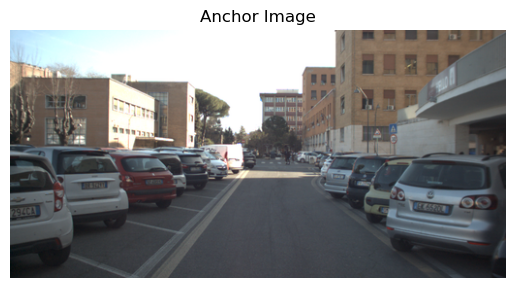

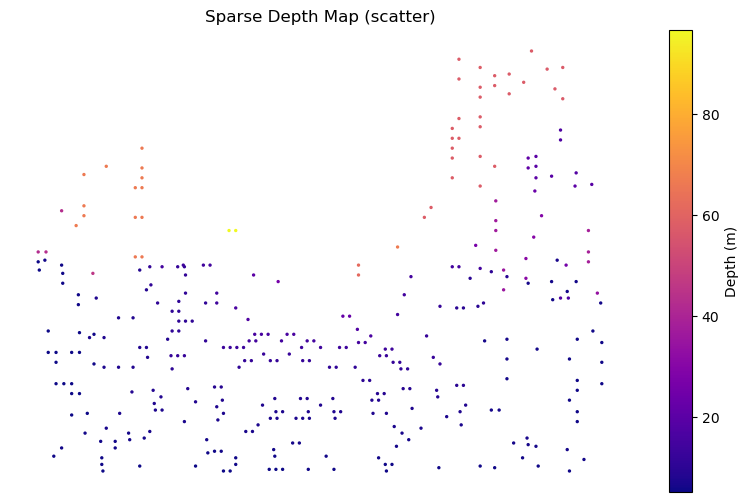

[[ 1.3550009e-01 -5.1895779e-04 -9.9077708e-01  5.8084782e+01]
 [ 9.9023598e-01 -3.2979455e-02  1.3544334e-01  1.2758797e+01]
 [-3.2745637e-02 -9.9945587e-01 -3.9548143e-03 -8.2344007e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [5]:
anchor, query = dataset[4]
print(anchor.keys())
print(anchor['img'].shape, anchor['depthmap'].shape)
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

img = anchor['img'].permute(1, 2, 0).numpy()  # CxHxW → HxWxC
img_vis = (img + 1.0) / 2.0  # Scale to [0, 1]

plt.imshow(img_vis)
plt.title("Anchor Image")
plt.axis("off")
plt.show()



import matplotlib.pyplot as plt
import numpy as np

depth = anchor['depthmap']
valid_mask = depth > 0

# Get coordinates of valid pixels
v_coords, u_coords = np.where(valid_mask)
depth_values = depth[v_coords, u_coords]

# Plot as scatter
plt.figure(figsize=(10, 6))
plt.scatter(u_coords, v_coords, c=depth_values, cmap='plasma', s=2, marker='o')
plt.gca().invert_yaxis()  # Match image coordinate system
plt.colorbar(label='Depth (m)')
plt.title("Sparse Depth Map (scatter)")
plt.axis('off')
plt.show()


print(query['camera_pose'])  # Should be 4x4


In [6]:
from mast3r.model import AsymmetricMASt3R


## this will convert the model to a local version
# model = AsymmetricMASt3R.from_pretrained("naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric")
# model.save_pretrained("/home/bjangley/VPR/mast3r-v2/checkpoints/mast3r_vitlarge_local")


In [7]:
# import torch
# from mast3r.model import AsymmetricMASt3R
# from mast3r.fast_nn import fast_reciprocal_NNs
# from dust3r.inference import inference

# device = 'cuda:6'
# checkpoint_path = "/home/bjangley/VPR/mast3r-old/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"

# # Load model from local checkpoint
# model = AsymmetricMASt3R.from_pretrained(checkpoint_path).to(device).eval()


In [8]:
# anchor, query = dataset[0]

# # --- Prepare views for inference (only 'img' is needed) ---
# # Dataset loading
# anchor, query = dataset[0]

# # Correctly wrap views
# view1 = {
#     'img': anchor['img'].unsqueeze(0),
#     'true_shape': np.int32([anchor['img'].shape[1:]]),
#     'idx': 0,
#     'instance': '0'
# }
# view2 = {
#     'img': query['img'].unsqueeze(0),
#     'true_shape': np.int32([query['img'].shape[1:]]),
#     'idx': 1,
#     'instance': '1'
# }

# # Final input format
# input_batch = [(view1, view2)]

# # Run inference
# with torch.no_grad():
#     output = inference(input_batch, model, device=device, batch_size=1, verbose=False)



# # --- Extract descriptors ---
# desc1 = output['pred1']['desc'].squeeze(0).detach()
# desc2 = output['pred2']['desc'].squeeze(0).detach()

# # --- Find 2D-2D matches ---
# matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
#                                                device=device, dist='dot', block_size=8192)

# # --- Visualize matches ---
# n_viz = 20
# num_matches = matches_im0.shape[0]
# match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
# viz_matches_im0 = matches_im0[match_idx_to_viz]
# viz_matches_im1 = matches_im1[match_idx_to_viz]

# image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
# image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

# viz_imgs = []
# for view in [view1, view2]:
#     rgb_tensor = view['img'] * image_std + image_mean
#     viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

# H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
# img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant')
# img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant')
# img = np.concatenate((img0, img1), axis=1)

# plt.figure(figsize=(12, 6))
# plt.imshow(img)
# cmap = plt.get_cmap('jet')
# for i in range(n_viz):
#     (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
#     plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)))
# plt.axis('off')
# plt.title("Sample Matches Between Anchor and Query")
# plt.show()

In [9]:
# import torch
# from mast3r.model import AsymmetricMASt3R
# from mast3r.fast_nn import fast_reciprocal_NNs
# from dust3r.inference import inference


# # device = 'cuda:6'
# # checkpoint_path = "/home/bjangley/VPR/mast3r-old/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"

# # model = AsymmetricMASt3R.from_pretrained(checkpoint_path).to(device).eval()

# from dust3r.losses import L21
# from mast3r.losses import ConfLoss, Regr3D, ConfMatchingLoss, MatchingLoss, InfoNCE

# train_criterion = (
#     ConfLoss(Regr3D(L21, norm_mode='avg_dis'), alpha=0.2)
#     + 0.075 * ConfMatchingLoss(
#         MatchingLoss(InfoNCE(mode='proper', temperature=0.05), negatives_padding=0, blocksize=8192),
#         alpha=10.0,
#         confmode='mean'
#     )
# )

# model.eval()

# # Move tensors in the batch to the correct device
# def move_to_device(view, device):
#     """Move all tensors in a view to the specified device."""
#     for key in view:
#         if isinstance(view[key], torch.Tensor):
#             view[key] = view[key].to(device)
#     return view

# # Extract views from the batch
# view1 = move_to_device(batch[0], device)
# view2 = move_to_device(batch[1], device)

# # Run the model forward pass
# with torch.no_grad():
#     outputs = model(view1, view2)
#     print("Model forward pass successful!")


In [10]:
# --- Imports ---
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from mast3r.datasets.base.vbr_pairs_dataset import VBRPairsDataset
from mast3r.model import AsymmetricMASt3R
from dust3r.losses import L21
from mast3r.losses import ConfLoss, Regr3D, ConfMatchingLoss, MatchingLoss, InfoNCE
from dust3r.inference import loss_of_one_batch

# # --- Paths ---
# ROOT = "/home/bjangley/VPR/vbr/spagna_train0_00"
# CALIB_YAML = "/home/bjangley/VPR/vbr/spagna_train0_00/vbr_calib.yaml"
# POSES = "/home/bjangley/VPR/vbr/spagna_train0_gt.txt"
# PAIRS_PATH="/home/bjangley/VPR/mast3r-v2/pairsVBR"
# OUTPUT_DIR = os.path.join(ROOT, "depthmaps_npy")
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # --- Dataset ---
# dataset = VBRPairsDataset(
#     root_dir=ROOT,
#     split="train",
#     pairs_txt=PAIRS_PATH,
#     calib_yaml=CALIB_YAML,
#     poses_txt=POSES,
#     depth_dir=OUTPUT_DIR,
#     resolution=[(512, 384)],  # width x height
#     n_corres=1000,
#     aug_crop=False
# )

# Reduce batch size to avoid CUDA OOM
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# --- Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint_path = "/home/bjangley/VPR/mast3r-old/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(checkpoint_path).to(device).train()

# --- Loss Function ---
train_criterion = ConfLoss(Regr3D(L21, norm_mode='?avg_dis', gt_scale=True), alpha=0.2).to(device)
# train_criterion = ConfLoss(Regr3D(L21, norm_mode='?avg_dis'), alpha=0.2) + 0.075*ConfMatchingLoss(MatchingLoss(InfoNCE(mode='proper', temperature=0.05), negatives_padding=0, blocksize=8192), alpha=10.0, confmode='mean')
# --- Optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
loss_scaler = torch.cuda.amp.GradScaler()  # Optional for mixed precision training

# def move_batch_to_device(batch, device):
#     """Move all tensors in a batch (list of views) to the specified device."""
#     for view in batch:  # Iterate over each view in the batch
#         for key, value in view.items():
#             if isinstance(value, torch.Tensor):
#                 view[key] = value.to(device)
#     return batch
# Check batch structure

# --- Training for One Epoch ---
model.train()
# for batch_idx, batch in enumerate(data_loader):
#     # Move batch (list of views) to device
#     # batch = move_batch_to_device(batch, device)
#     # Forward pass
#     # Check batch structure

#     with torch.cuda.amp.autocast():
#         # Use 'train_criterion' instead of undefined 'criterion'
#         # print(view0['camera_pose'])
#         loss_tuple = loss_of_one_batch(batch, model, train_criterion, device, symmetrize_batch=True, use_amp=True, ret='loss')
#         loss, loss_details = loss_tuple
#         loss, loss_details = loss_tuple

#     # Backward pass -- does not save the model right now
#     optimizer.zero_grad()
#     loss_scaler.scale(loss).backward()
#     loss_scaler.step(optimizer)
#     loss_scaler.update()

#     # Print loss
#     print(f"Batch {batch_idx}, Loss: {loss.item()}")

# print("Training for one epoch completed!")

... loading model from /home/bjangley/VPR/mast3r-old/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


/tmp/ipykernel_1266923/4020290571.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  loss_scaler = torch.cuda.amp.GradScaler()  # Optional for mixed precision training


AsymmetricMASt3R(
  (patch_embed): PatchEmbedDust3R(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (mask_generator): RandomMask()
  (rope): cuRoPE2D()
  (enc_blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (rope): cuRoPE2D()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.

In [11]:
# # --- Training for One Epoch ---
# model.train()
# for batch_idx, batch in enumerate(data_loader):
#     # Debug: Check batch structure (batch is a list of views)
#     print(f"Batch type: {type(batch)}")
#     print(f"Number of views in batch: {len(batch)}")
    
#     # Inspect each view in the batch
#     for i, view in enumerate(batch):
#         print(f"View {i} keys: {list(view.keys())}")
#         # Check if 'valid_corres' exists
#         if 'valid_corres' in view:
#             print(f"View {i} has valid_corres: {view['valid_corres'].shape}")
#         else:
#             print(f"View {i} missing 'valid_corres'")

#     try:
#         with torch.cuda.amp.autocast():
#             loss_tuple = loss_of_one_batch(batch, model, train_criterion, device, 
#                                          symmetrize_batch=True, use_amp=True, ret='loss')
#             loss, loss_details = loss_tuple

#         # Backward pass
#         optimizer.zero_grad()
#         loss_scaler.scale(loss).backward()
#         loss_scaler.step(optimizer)
#         loss_scaler.update()

#         print(f"Batch {batch_idx}, Loss: {loss.item()}")
        
#     except KeyError as e:
#         print(f"KeyError in batch {batch_idx}: {e}")
#         print("Available keys in views:")
#         for i, view in enumerate(batch):
#             print(f"  View {i}: {list(view.keys())}")
#         break
#     except Exception as e:
#         print(f"Error in batch {batch_idx}: {e}")
#         break

# print("Training completed!")

In [12]:
# print(model)
print(model)
print(model.downstream_head1)

AsymmetricMASt3R(
  (patch_embed): PatchEmbedDust3R(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (mask_generator): RandomMask()
  (rope): cuRoPE2D()
  (enc_blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (rope): cuRoPE2D()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.